# <center>Northwind Traders Business Exploration Project</center>

## 1. Introduction:

In this notebook we will test various hypotheses for a database containing sales data for Northwind Traders, a specialty foods import-export company. The table structure of the database can be seen in the diagram below:

<img src="files/northwind.jpg">

#### 1.1 Import the Northwind database and print the table names

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Northwind_small.sqlite')
table_names = engine.table_names()
print(table_names)
table_names = ['Category', 'Customer', 'Employee', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


#### 1.2 Print the column names for each table

In [2]:
import pprint
import numpy as np
for name in table_names:
    con = engine.connect()
    rs = con.execute("SELECT * FROM [" + name +"]")
    df = pd.DataFrame(rs.fetchall())
    df.columns = rs.keys()
    print(name + ':')
    print()
    print("\n".join(sorted(list(df.columns))))
    print('__________________________')
    print()

Category:

CategoryName
Description
Id
__________________________

Customer:

Address
City
CompanyName
ContactName
ContactTitle
Country
Fax
Id
Phone
PostalCode
Region
__________________________

Employee:

Address
BirthDate
City
Country
Extension
FirstName
HireDate
HomePhone
Id
LastName
Notes
Photo
PhotoPath
PostalCode
Region
ReportsTo
Title
TitleOfCourtesy
__________________________

Order:

CustomerId
EmployeeId
Freight
Id
OrderDate
RequiredDate
ShipAddress
ShipCity
ShipCountry
ShipName
ShipPostalCode
ShipRegion
ShipVia
ShippedDate
__________________________

OrderDetail:

Discount
Id
OrderId
ProductId
Quantity
UnitPrice
__________________________

Product:

CategoryId
Discontinued
Id
ProductName
QuantityPerUnit
ReorderLevel
SupplierId
UnitPrice
UnitsInStock
UnitsOnOrder
__________________________

Region:

Id
RegionDescription
__________________________

Shipper:

CompanyName
Id
Phone
__________________________

Supplier:

Address
City
CompanyName
ContactName
ContactTitle
Country
Fa

***
***
<br>

# 2. Question One: 
## Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

***
#### 2.1 Hypothesis Test:

Null Hypothesis &nbsp; ($H_{0}$): &emsp;&emsp;&emsp;&emsp;&ensp; $μ_{Discount}$&ensp;=&ensp;$μ_{NoDiscount}$<br><br>Alternative Hypothesis &nbsp; ($H_{a}$):&emsp;&ensp;&ensp; $μ_{Discount}$&ensp;≠&ensp;$μ_{NoDiscount}$

The μ in the hypothesis above references the mean number of products purchased for orders placed with and without a discount. For this hypothesis test, we will be using a significance level ($\alpha$) to 0.05 or 5%.

#### 2.2 Create Dataframe of pertinent information:

In [3]:
con = engine.connect()
rs = con.execute("SELECT * FROM [OrderDetail]")
df_OD = pd.DataFrame(rs.fetchall()) 
df_OD.columns = rs.keys()
df1 = df_OD[['Quantity','Discount']]
df1.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


#### 2.3 Check parametric-test assumptions:

1. The data is continuous.
2. The data is normally distributed.
3. The two samples are independent of eachother.
4. Both samples are simple random samples from their respective populations.
5. The variances of the two populations are equal.

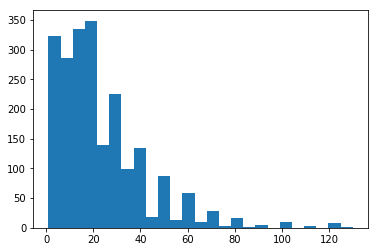

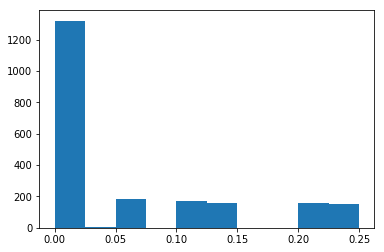

In [4]:
# Create histograms to check for continuity and normality
from numpy.random import seed
import matplotlib.pyplot as plt
%matplotlib inline
# seed the random number generator
seed(1)
# histogram plot
plt.hist(df1['Quantity'], bins=25)
plt.show();
plt.hist(df1['Discount'])
plt.show();

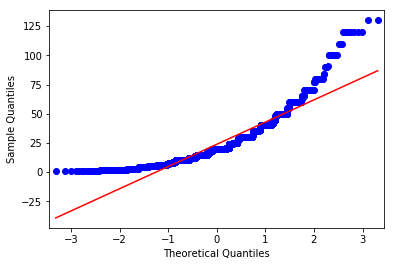

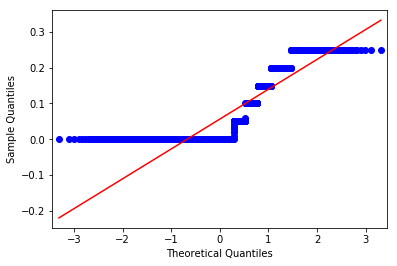

In [5]:
# Create QQ Plots to further check normality
from statsmodels.graphics.gofplots import qqplot
qqplot(df1['Quantity'], line='s')
plt.show()
qqplot(df1['Discount'], line='s')
plt.show()

The independent variable (level of discount) is clearly discrete, but as long as the dependent variable can be considered continous, the first assumption is met. 

In addition, both the independent and dependent variables are skewed, but the Central Limit Theorem allows for the second assumption to be met. The Central Limit Theorem states the sample means of moderately large samples (n>100) are often well-approximated by a normal distribution even if the populations are not normally distributed.

The two samples are independent and randomly taken, so assumptions three and four are met.

In [6]:
Discount_list = list(df1.loc[df1['Discount'] != 0.0]['Quantity'])
No_Discount_list = list(df1.loc[df1['Discount'] == 0.0]['Quantity'])
print('Discount Variance: ',str(round(np.var(Discount_list))))
print('No-Discount Variance: ',str(round(np.var(No_Discount_list))))

Discount Variance:  431.0
No-Discount Variance:  306.0


The variances of the two populations ar not equal. Although the fifth assumption is not met, we can still use Welch's t-test, or the unequal variances t-test.

#### 2.4 Chi-Squared Independence Test

The chi-square independence test will be employed to first test if the quantity and discount variables are related in the population.

In [7]:
# Separate the dataframe into two groups (Discount and No-Discount)
Quantities = list(df1['Quantity'].unique())
Quantities.sort()
df_Dis = df1.loc[df1['Discount'] > 0]
df_No_Dis = df1.loc[df1['Discount'] == 0]
print(len(df_Dis),len(df_No_Dis))

838 1317


In [8]:
# Count the number of times each quantity appears in the No-Discount data
from collections import Counter 
cnt = Counter()
for quantity in df_No_Dis['Quantity']:
    cnt[quantity] += 1

In [9]:
# Create new testing dataframe and add a row containing the No-Discount counts
df_new = pd.DataFrame(columns = Quantities)

for q in Quantities:
    for c in cnt.keys():
        if q == c:
            df_new.loc[df1.index[0], q] = cnt[c]
df_new.loc[df_new.index[0]].sum()

1317

In [10]:
# Add a second row containing the Discount counts and show the new test dataframe
cnt2 = Counter()
for quantity in df_Dis['Quantity']:
    cnt2[quantity] += 1

for q in Quantities:
    for c in cnt2.keys():
        if q == c:
            df_new.loc[df1.index[1], q] = cnt2[c]
df_new

,1,2,3,4,5,6,7,8,9,10,...,70,77,80,84,90,91,100,110,120,130
0,13,30,34,39,53,62,17,29,22,130,...,10,1,6,NaN,1,1,4,3,3,1
1,4,22,12,16,14,25,6,21,8,51,...,18,2,10,2,3,NaN,6,NaN,5,1


In [11]:
# Fill missing values with zeroes
pd.set_option('display.max_columns', 100)
df_new.fillna(0, inplace=True)
df_new

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,21,22,24,25,27,28,30,32,33,35,36,39,40,42,44,45,48,49,50,52,54,55,56,60,63,65,66,70,77,80,84,90,91,100,110,120,130
0,13,30,34,39,53,62,17,29,22,130,0,57,1,28,100,21,24,154,30,1,36,44,0,18,122,3,1,42,9,2,60,8,2,9,3,3,40,1,0,4,1,30,1,3,0,10,1,6,0,1,1,4,3,3,1
1,4,22,12,16,14,25,6,21,8,51,2,35,2,8,69,14,23,98,20,0,22,36,2,11,72,2,1,29,12,0,53,11,2,5,2,4,35,0,1,5,2,28,0,5,1,18,2,10,2,3,0,6,0,5,1


In [12]:
# To ensure validity of the Chi-Squared test, columns containg values that are both less than 5 are removed
for column in df_new:
    if (df_new[column][0] < 5) & (df_new[column][1] < 5):
        df_new.drop(column,axis=1,inplace=True)
df_new

,1,2,3,4,5,6,7,8,9,10,12,14,15,16,18,20,21,24,25,28,30,35,36,40,42,45,50,55,60,65,70,80,100,120
0,13,30,34,39,53,62,17,29,22,130,57,28,100,21,24,154,30,36,44,18,122,42,9,60,8,9,40,4,30,3,10,6,4,3
1,4,22,12,16,14,25,6,21,8,51,35,8,69,14,23,98,20,22,36,11,72,29,12,53,11,5,35,5,28,5,18,10,6,5


In [13]:
# Run Chi-Squared Independence Test for the contigency table
from scipy.stats import chi2_contingency
x = list(df_new.iloc[0]), list(df_new.iloc[1])
obs = np.array(x)
print("Chi Squared Statistic: ", chi2_contingency(obs)[0])
print("Degrees of Freedom: ", chi2_contingency(obs)[2])
print("P-Value: ", chi2_contingency(obs)[1])

Chi Squared Statistic:  72.02930176656024
Degrees of Freedom:  33
P-Value:  0.00010001005316213599


The P-vale us well below our alpha value (0.05), so we can say there is a statistically significant relationship between the quantity and discount of an order. We will next use Welch's T-Test and ANOVA testing to further explore this relationship.

#### 2.5 Welch's T-Test

In [14]:
# Run Welch's T-Test by setting equal_var = False
import scipy.stats as stat
stat.ttest_ind(list(df_Dis['Quantity']),list(df_No_Dis['Quantity']), equal_var=False)

Ttest_indResult(statistic=6.239069142123973, pvalue=5.65641429030433e-10)

The P-Value for the Welch's T-Test is also below our significance level of 0.05. We can then reject the null hypothesis and say the mean quantity of orders with a discount is not equal to the mean quantity of orders without a discount.

#### 2.6 Multiple Comparison Analysis Testing in ANOVA

In [15]:
# Show description of statistics for differing discount levels
df1['Quantity'].groupby(df1['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


In [16]:
# Remove discount levels with counts that are less than 5
discounts = ['0','0.0','0.05','0.10','0.15','0.20','0.25']
df1 = df1.loc[df1['Discount'].isin(discounts)]
df1['Quantity'].groupby(df1['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0
0.20,161.0,27.024845,18.832801,2.0,12.0,21.0,40.0,100.0
0.25,154.0,28.240260,20.120570,2.0,15.0,25.0,36.0,120.0


In [17]:
# Import packages and run Tukey's range test to check how much of a discount has an effect on quantity
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(df1['Quantity'], df1['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   6.2955   2.0814 10.5097  True 
 0.0    0.1    3.5217  -0.8187  7.8622 False 
 0.0    0.15   6.6669   2.1352 11.1986  True 
 0.0    0.2    5.3096   0.8285  9.7907  True 
 0.0    0.25   6.525    1.954   11.096  True 
 0.05   0.1   -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.2    -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.1    0.15   3.1452   -2.771  9.0613 False 
 0.1    0.2    1.7879  -4.0896  7.6653 False 
 0.1    0.25   3.0033   -2.943  8.9496 False 
 0.15   0.2   -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.2    0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


#### 2.7 Results

Using the Chi-Squared Independence test, we were first able to show there was a statistically significant relationship between quantity and discount of an order. Next, we rejected our initial hypothesis and stated there is a difference between the mean quantity of orders with a discount and mean quantity of orders without a discount. Finally, using a Tukey's range test we were able to determine that discount levels of 5%, 15%, 20%, and 25% showed a statistically significant difference in quantity means when compared to orders with no discount.

***
***
<br>

# 3. Question Two:
## Does the category of products purchased have a statistically significant effect on the quantity of the order?

***
#### 3.1 Hypothesis Test:

Null Hypothesis &nbsp; ($H_{0}$): &emsp;&emsp;&emsp;&emsp;&ensp; $μ_{Category1}$&ensp;=&ensp;$μ_{Category2}$<br><br>Alternative Hypothesis &nbsp; ($H_{a}$):&emsp;&ensp;&ensp; $μ_{Category1}$&ensp;≠&ensp;$μ_{Category2}$

The μ in the hypothesis above references the mean number of products purchased for orders placed for differing product categories. This hypothesis test will be ran for each combination of categories. For these hypothesis tests, we will use a significance level ($\alpha$) to 0.05 or 5%.

#### 3.2 Create Dataframe of pertinent information:

In [18]:
rs = con.execute("SELECT * FROM [OrderDetail] JOIN Product ON OrderDetail.ProductId = Product.Id")
df_Cat = pd.DataFrame(rs.fetchall()) 
df_Cat.columns = rs.keys()
df_Cat.drop(df_Cat.columns[11], axis=1, inplace=True)
df2 = df_Cat[['Quantity', 'CategoryId']]
df2.head()

,Quantity,CategoryId
0,12,4
1,10,5
2,5,4
3,9,7
4,40,7


#### 3.3 Check Parametric-Test Assumptions

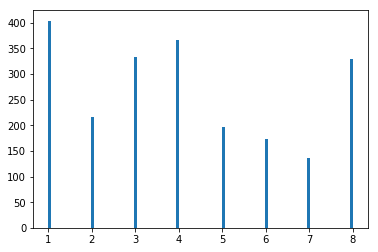

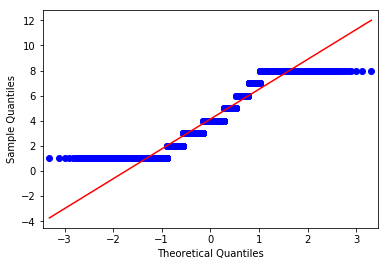

In [19]:
plt.hist(df2['CategoryId'], bins=100)
plt.show()
qqplot(df2['CategoryId'], line='s')
plt.show()

Similar to before, the independent variable (category) is clearly discrete, but we will assume the dependent variable is continuous. We meet the second assumption of normality based on Central Limit Theorem and sample size. The two samples are independent and randomly taken, so assumptions three and four are met.

#### 3.4 Chi-Squared Independence Test and Welch's T-Test

In [20]:
# Create a list of all possible combinations of categories
from itertools import combinations
combs = list(combinations(range(1,9), 2))
combs

[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 4),
 (3, 5),
 (3, 6),
 (3, 7),
 (3, 8),
 (4, 5),
 (4, 6),
 (4, 7),
 (4, 8),
 (5, 6),
 (5, 7),
 (5, 8),
 (6, 7),
 (6, 8),
 (7, 8)]

In [21]:
# Create a dataframe to hold the results of the tests
df_Categories = pd.DataFrame(columns=('Comparison','Chi-Squared Statistic', 'Degrees of Freedom', 'P-Value', 'T-Test Statistic', 'T-Test P-Value', 'First Average Quantity', 'Second Average Quantity'))
index = 0

# Run Chi-Squared test for each combination
for comb in combs:
    
    # Create testing dataframe
    df_comb = pd.DataFrame(columns = Quantities)
    
    # Create Category1 dataset
    df_Cat1 = df2.loc[df2['CategoryId'] == comb[0]]
    
    # Create Category2 dataset
    df_Cat2 = df2.loc[df2['CategoryId'] == comb[1]]

    # Count quantities for Catgory1 and add as row to testing dataframe
    count1 = Counter()
    for quantity in df_Cat1['Quantity']:
        count1[quantity] += 1

    for q in Quantities:
        for c in count1.keys():
            if q == c:
                df_comb.loc[df2.index[0], q] = count1[c]
    
    # Count quantities for Catgory2 and add as row to testing dataframe       
    count2 = Counter()
    for quantity in df_Cat2['Quantity']:
        count2[quantity] += 1

    for q in Quantities:
        for c in count2.keys():
            if q == c:
                df_comb.loc[df2.index[1], q] = count2[c]
            
    #Fill missing values with zeroes and remove columns with counts less than 3
    df_comb.fillna(0, inplace=True)
    for i in df_comb.columns:
        if df_comb[i][0] < 3 and df_comb[i][1] < 3:
            df_comb.drop(i, axis=1, inplace=True)
            
    new_list = []
    new_list2 = []
    for i in df_comb.columns:
        new_list.append(i*df_comb[i][0])
        new_list2.append(df_comb[i][0])
        
    new_list3 = []
    new_list4 = []
    for i in df_comb.columns:
        new_list3.append(i*df_comb[i][1])
        new_list4.append(df_comb[i][1])
        
    # Run Chi-Squared Independence Test
    x = list(df_comb.iloc[0]), list(df_comb.iloc[1])
    obs = np.array(x)
    Col = "Cat " + str(comb[0]) + " vs. Cat " + str(comb[1])
    Chi = chi2_contingency(obs)[0]
    Deg = chi2_contingency(obs)[2]
    PV = chi2_contingency(obs)[1]
    
    # Run Welch's T-Test    
    welch = list(stat.ttest_ind(df_Cat1['Quantity'],df_Cat2['Quantity'], equal_var=False))
    T_test_stat = str(round(welch[0],3))
    T_test_p = str(round(welch[1],3))
    
    # Calculate average quantity for orders of each category
    Avg1 = round(sum(new_list)/sum(new_list2),1)
    Avg2 = round(sum(new_list3)/sum(new_list4),1)
    
    # Add results to results dataframe
    row = np.array([Col, Chi, Deg, PV, T_test_stat, T_test_p, Avg1, Avg2])
    df_Categories.loc[index] = row
    index += 1
    
# Print rows with a Chi-Squared or Welch's T-Test P-Value below 0.05
df_Categories.sort_values(by=['P-Value'], inplace=True)
df_Categories.loc[(df_Categories['P-Value'].astype(float) < 0.05) | (df_Categories['T-Test P-Value'].astype(float) < 0.05)]

,Comparison,Chi-Squared Statistic,Degrees of Freedom,P-Value,T-Test Statistic,T-Test P-Value,First Average Quantity,Second Average Quantity
0,Cat 1 vs. Cat 2,51.44082105479313,30,0.008744506492391349,-0.566,0.572,21.9,22.6
14,Cat 3 vs. Cat 5,44.31084325119079,28,0.025877352209525938,0.245,0.806,22.7,21.6
18,Cat 4 vs. Cat 5,45.73545973093878,30,0.0329266540967386,1.055,0.292,24.0,22.1
13,Cat 3 vs. Cat 4,45.456965897010235,31,0.04536873105148003,-0.973,0.331,22.7,24.2


In [22]:
# Create Category reference table
con = engine.connect()
rs = con.execute("SELECT * FROM [Category]")
df_Cat_names = pd.DataFrame(rs.fetchall()) 
df_Cat_names.columns = rs.keys()
df_Cat_names

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


#### 3.5 Results

Using the Chi-Squared Independence test, we were first able to determine there is a statistically significant relationship between quantity and category when comparing datasets of the following categories:

1. Beverages vs. Condiments
2. Confections vs. Grains/Cereals
3. Dairy Products vs. Grains/Cereals
4. Confections vs. Dairy Products

Although we can say there is relationship between the category and quanitity variables, the P-value for the Welch's T-Test for all combinations of categories was above our significance value of 0.05. Therefore, we cannot reject the null hypothesis; there is no difference in means of the quanitity of an order when comparing product categories.

***
***
<br>

# 4. Question Three:
## Does the region a customer is from have a statistically significant effect on the total amount of their order?

***
#### 4.1 Hypothesis Test:

Null Hypothesis &nbsp; ($H_{0}$): &emsp;&emsp;&emsp;&emsp;&ensp; $μ_{Americas}$&ensp;=&ensp;$μ_{Europe}$<br><br>Alternative Hypothesis &nbsp; ($H_{a}$):&emsp;&ensp;&ensp; $μ_{Americas}$&ensp;≠&ensp;$μ_{Europe}$

The μ in the hypothesis above references the mean order total for orders placed from Europe and the Americas. For this hypothesis test, we will use a significance level (α) to 0.05 or 5%.

#### 4.2 Create dataframe of pertinent information

In [23]:
rs = con.execute("SELECT * FROM [OrderDetail]  JOIN [Order] ON OrderDetail.OrderId = [Order].Id")
df_Reg = pd.DataFrame(rs.fetchall()) 
df_Reg.columns = rs.keys()
df_Reg.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248/11,10248,11,14.0,12,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10248/42,10248,42,9.8,10,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
2,10248/72,10248,72,34.8,5,0.0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
3,10249/14,10249,14,18.6,9,0.0,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
4,10249/51,10249,51,42.4,40,0.0,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany


In [24]:
df3 = df_Reg[['OrderId','UnitPrice','Quantity','ShipRegion']]
df3.head()
df3['ShipRegion'].unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', 'Eastern Europe'], dtype=object)

In [25]:
# Add "Total" column, which is the total price of all products purchased for each order
all_orders = df3['OrderId'].unique()

for order in list(all_orders):
    sum_list = []
    y = list(df3.loc[df3['OrderId'] == int(order), 'UnitPrice'].index)
    z = len(df3.loc[df3['OrderId'] == order])
    for i in list(range(y[0],y[0]+z)):
        x = (df3.loc[df3['OrderId'] == int(order), 'UnitPrice'][i])*(df3.loc[df3['OrderId'] == int(order), 'Quantity'][i])
        sum_list.append(x)
        df3.loc[df3['OrderId'] == order, 'Total'] = sum(sum_list)
df3.head()

,OrderId,UnitPrice,Quantity,ShipRegion,Total
0,10248,14.0,12,Western Europe,440.0
1,10248,9.8,10,Western Europe,440.0
2,10248,34.8,5,Western Europe,440.0
3,10249,18.6,9,Western Europe,1863.4
4,10249,42.4,40,Western Europe,1863.4


In [26]:
# Convert ShipRegion column into two categories (Europe and Americas)
df3 = df3[['OrderId','ShipRegion', 'Total']]
df3.drop_duplicates(inplace=True)
df3['ShipRegion'].unique()
regions = ['Western Europe', 'Northern Europe', 'Scandinavia', 'Southern Europe', 'British Isles', 'Eastern Europe'] 
for region in regions:
    df3.loc[df3['ShipRegion'] == region, 'BroadRegion'] = 'Europe'
df3 = df3.fillna('Americas')
df3.head()

,OrderId,ShipRegion,Total,BroadRegion
0,10248,Western Europe,440.0,Europe
3,10249,Western Europe,1863.4,Europe
5,10250,South America,1813.0,Americas
8,10251,Western Europe,670.8,Europe
11,10252,Western Europe,3730.0,Europe


#### 4.3 Check Parametric-Test Assumptions

The independent variable (Region) is discrete, but the dependent variable (Total Price) is continuous. We meet the second assumption of normality based on Central Limit Theorem and sample size. The two samples are independent and randomly taken, so assumptions three and four are met.

In [27]:
# Check for equal variance
Europe_list = list(df3.loc[df3['BroadRegion'] == 'Europe']['Total'])
Americas_list = list(df3.loc[df3['BroadRegion'] == 'Americas']['Total'])
print('Europe Variance: ',str(round(np.var(Europe_list))))
print('Americas Variance: ',str(round(np.var(Americas_list))))

Europe Variance:  3687608.0
Americas Variance:  4377370.0


The two samples have different variances, so the Welch's t-test will be employed.

#### 4.4 Welch's T-Test

In [28]:
welch = list(stat.ttest_ind(Europe_list,Americas_list, equal_var=False))
print("Statistic: ",str(round(welch[0],3)))
print("P-Value: ",str(round(welch[1],3)))

Statistic:  0.122
P-Value:  0.903


#### 4.5 Results

The P-value for our Welch's t-test is much larger than our significance level of 0.05. For this reason, we cannot reject the null hypothesis. There is no statistically significant difference between the mean order total for orders placed in the Americas vs. orders placed in Europe.

***
***
<br>

# 5. Question Four:
## Does the country a customer is from have a statistically significant effect on the total amount of their order?

***
#### 5.1 Hypothesis Test:

Null Hypothesis &nbsp; ($H_{0}$): &emsp;&emsp;&emsp;&emsp;&ensp; $μ_{Country1}$&ensp;=&ensp;$μ_{Country2}$<br><br>Alternative Hypothesis &nbsp; ($H_{a}$):&emsp;&ensp;&ensp; $μ_{Country1}$&ensp;≠&ensp;$μ_{Country2}$

The μ in the hypothesis above references the mean order total for orders placed in different countries. This hypothesis test will be ran for each combination of countries. For these hypothesis tests, we will use a significance level (α) to 0.05 or 5%.

#### 5.2 Create dataframe of pertinent information

In [29]:
con = engine.connect()
rs = con.execute("SELECT * FROM [OrderDetail] JOIN [Order] ON [Order].Id = OrderDetail.OrderId JOIN Customer ON Customer.Id = [Order].CustomerId")
df_Countries = pd.DataFrame(rs.fetchall()) 
df_Countries.columns = rs.keys()
df4 = df_Countries[['OrderId', 'UnitPrice', 'Quantity', 'Country']]
df4.head()

,OrderId,UnitPrice,Quantity,Country
0,10248,14.0,12,France
1,10248,9.8,10,France
2,10248,34.8,5,France
3,10249,18.6,9,Germany
4,10249,42.4,40,Germany


In [30]:
# Add "Total" column, which is the total price of all products purchased for each order
all_orders = df4['OrderId'].unique()

for order in list(all_orders):
    sum_list = []
    y = list(df4.loc[df4['OrderId'] == int(order), 'UnitPrice'].index)
    z = len(df4.loc[df4['OrderId'] == order])
    for i in list(range(y[0],y[0]+z)):
        x = (df4.loc[df4['OrderId'] == int(order), 'UnitPrice'][i])*(df4.loc[df4['OrderId'] == int(order), 'Quantity'][i])
        sum_list.append(x)
        df4.loc[df4['OrderId'] == order, 'Total'] = sum(sum_list)

In [31]:
# Remove countries with less than 30 orders, and create a list of all combinations of remaining countries
countries = df4['Country'].unique()
final_countries = []
df4 = df4[['OrderId', 'Country', 'Total']]
df4.drop_duplicates(inplace=True)
for country in countries:
    if len(df4.loc[df4['Country'] == country]) > 29:
        final_countries.append(country)
            
df4 = df4.loc[df4['Country'].isin(final_countries)]
combs_countries = list(combinations(final_countries, 2))
combs_countries

[('France', 'Germany'),
 ('France', 'Brazil'),
 ('France', 'Venezuela'),
 ('France', 'Austria'),
 ('France', 'USA'),
 ('France', 'Sweden'),
 ('France', 'UK'),
 ('France', 'Canada'),
 ('Germany', 'Brazil'),
 ('Germany', 'Venezuela'),
 ('Germany', 'Austria'),
 ('Germany', 'USA'),
 ('Germany', 'Sweden'),
 ('Germany', 'UK'),
 ('Germany', 'Canada'),
 ('Brazil', 'Venezuela'),
 ('Brazil', 'Austria'),
 ('Brazil', 'USA'),
 ('Brazil', 'Sweden'),
 ('Brazil', 'UK'),
 ('Brazil', 'Canada'),
 ('Venezuela', 'Austria'),
 ('Venezuela', 'USA'),
 ('Venezuela', 'Sweden'),
 ('Venezuela', 'UK'),
 ('Venezuela', 'Canada'),
 ('Austria', 'USA'),
 ('Austria', 'Sweden'),
 ('Austria', 'UK'),
 ('Austria', 'Canada'),
 ('USA', 'Sweden'),
 ('USA', 'UK'),
 ('USA', 'Canada'),
 ('Sweden', 'UK'),
 ('Sweden', 'Canada'),
 ('UK', 'Canada')]

#### 5.3 Welch's T-Test

In [32]:
# Create dataframe to hold results
df_comparison = pd.DataFrame(columns=('Comparison', 'T-Test Statistic', 'T-Test P-Value', 'First Average Quantity', 'Second Average Quantity'))

for comb in combs_countries:
    
    # Create Country1 dataset
    df_Country1 = df4.loc[df4['Country'] == comb[0]]
    
    # Create Country2 dataset
    df_Country2 = df4.loc[df4['Country'] == comb[1]]
    
    # Run Welch's t-test for each combination of countries
    welch = list(stat.ttest_ind(df_Country1['Total'],df_Country2['Total'], equal_var=False))
    T_test_stat = str(round(welch[0],3))
    T_test_p = str(round(welch[1],3))    
    
    # Calculate average order total for each country
    Avg1 = round(sum(df_Country1['Total'])/len(df_Country1),1)
    Avg2 = round(sum(df_Country2['Total'])/len(df_Country2),1)
    
    # Add statistics to results dataframe
    Col = str(comb[0]) + ' vs. ' + str(comb[1])
    row = np.array([Col, T_test_stat, T_test_p, Avg1, Avg2])
    df_comparison.loc[index] = row
    index += 1
    
df_comparison.sort_values(by=['First Average Quantity'], inplace=True, ascending=False)
df_comparison.loc[df_comparison['T-Test P-Value'].astype(float) < 0.05]

,Comparison,T-Test Statistic,T-Test P-Value,First Average Quantity,Second Average Quantity
54,Austria vs. USA,2.947,0.004,3487.4,2160.4
56,Austria vs. UK,5.836,0.0,3487.4,1082.4
57,Austria vs. Canada,2.959,0.004,3487.4,1844.5
55,Austria vs. Sweden,4.166,0.0,3487.4,1608.7
59,USA vs. UK,4.056,0.0,2160.4,1082.4
41,Germany vs. UK,3.507,0.001,2005.3,1082.4
38,Germany vs. Austria,-3.303,0.002,2005.3,3487.4
37,Germany vs. Venezuela,2.621,0.01,2005.3,1322.1
36,Germany vs. Brazil,2.478,0.014,2005.3,1210.6
49,Venezuela vs. Austria,-5.275,0.0,1322.1,3487.4


#### 5.4 Results

Using Welch's t-test, we were able to determine that there are 16 country pairs that have statistically significant differences in order total means at 0.05 level. Countries such as Austria, USA, Germany higher order total means and countries such as France, Brazil, and Venezuela have lower order total means when compared to most other countries.


***
***
<br>

# 6. Conclusion

Through our various hypotheses tests, we were able to come to the following conclusions:
1. There is a statistically significant relationship between quantity and discount of an order. Furthermore, there is a statistically significant difference between the mean quantity of orders with a discount of 5%, 15%, 20%, and 25% and mean quantity of orders without a discount.
<br>

2. There is a statistically significant relationship between quantity and category when comparing datasets of the following categories:

        1.Beverages vs. Condiments
        2.Confections vs. Grains/Cereals
        3.Dairy Products vs. Grains/Cereals
        4.Confections vs. Dairy Products

    There is, however, no difference in means of the quanitity of an order when comparing product categories.
<br>

3. There is no statistically significant difference between the mean order total for orders placed in the Americas vs. orders placed in Europe.
<br>

4. There are 16 country pairs that have statistically significant differences in order total means. Countries such as Austria, USA, Germany have higher order total means when compared to countries such as France, Brazil, and Venezuela.
<br>
***
To further expand on the research performed in this notebook, the following questions should be explored:
1. What is the relationship we found between the categories in Question 2? Are customers more likely to buy these products together, or separately?
<br>

2. Does the effect of percentage of discount on quantity or order total differ by country?
<br>

3. Are customers from different countries more likely to purchase products from certain categories than others?